# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.monkey_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)


%run "_dataset-selection.ipynb"

the variable `GoodDataList` contains the session names


# CCA comparison

## **Mr.T** with another monkey, same epoch

load the data

In [2]:
full_list_MCx = []
for animal, sessionList in GoodDataList[defs.areas[2]].items():
    full_list_MCx.append((animal,sessionList))
full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
# load the DFs
warnings.filterwarnings("ignore")
allDFs_MCx = []
for animal, session in full_list_MCx:
    path = root / animal / session
    allDFs_MCx.append(defs.prep_general(dt.load_pyal_data(path)))
warnings.filterwarnings("default")


pairFileList1 = []
for I, (animal1,session1) in enumerate(full_list_MCx):
    if 'Mr' not in animal1:
        continue
    for J, (animal2,session2) in enumerate(full_list_MCx):
        if animal1 == animal2: continue  # to repetitions
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')

len(pairFileList1)=63


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

min_trials=15
min_time=15


Text(0.5, 0, 'sessions')

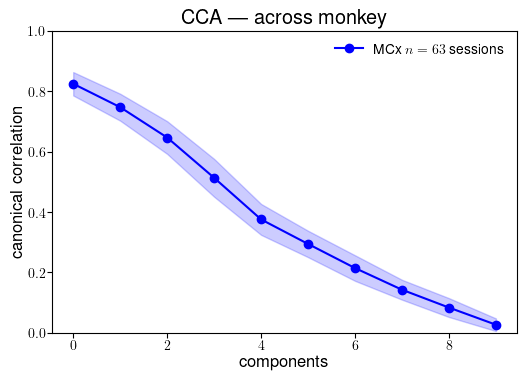

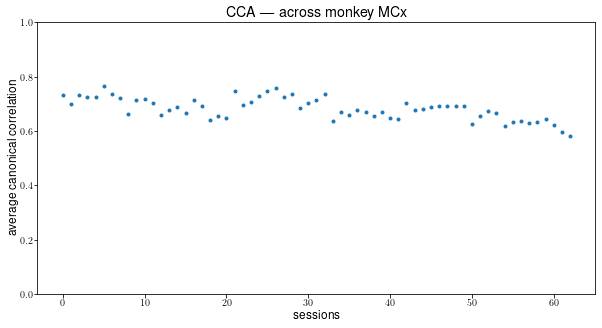

In [3]:
side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

warnings.filterwarnings("default")

allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs0.append(dt.canoncorr(data1, data2))
allCCs0 = np.array(allCCs0).T

# plot
_,ax = plt.subplots(dpi=100)
utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{defs.areas[2]} $n={allCCs0.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across monkey', usetex=True);

_,ax = plt.subplots(ncols=1, figsize=(10,5))
ax.plot(allCCs0[:4,:].mean(axis=0),'.')
ax.set_ylabel('average canonical correlation')
ax.set_title(f'CCA --- across monkey {defs.areas[2]} ', usetex=True);
ax.set_ylim([0,1])
ax.set_xlabel('sessions')


# lower bound

In [7]:
n_iter = params.n_iter * 10  #1000

#MCx
side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
side2df = [allDFs_MCx[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.prep_epoch, area=defs.areas[2], model=defs.n_components)
AllData1_ = dt.get_data_array(side2df, defs.fixation_epoch, area=defs.areas[2], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

warnings.filterwarnings("default")

inCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData1_):
    r = []
    for n in range(n_iter):
        sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
        sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

        data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
        r.append(dt.canoncorr(data1, data2))
    inCCs0.append(r)
inCCs0 = np.array(inCCs0)
CC_lower_bound_MCx = np.percentile(inCCs0, 1, axis=1).T


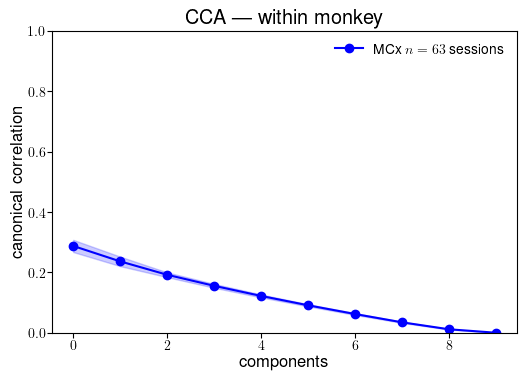

In [9]:
_,ax = plt.subplots(dpi=100)

utility.shaded_errorbar(ax, CC_lower_bound_MCx, color='b', marker = 'o', label=f'{defs.areas[2]} $n={CC_lower_bound_MCx.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- within monkey');

# upper bound

In [11]:
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(allDFs_MCx, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)

warnings.filterwarnings("default")

In [12]:
n_iter = params.n_iter * 10  #1000

n_shared_trial1 = AllData1.shape[2]
trialList1 = np.arange(n_shared_trial1)


CCs1=[]
for session, sessionData in enumerate(AllData1):
    r = []
    for n in range(n_iter):
        params.rng.shuffle(trialList1)
        # non-overlapping randomised trials
        trial1 = trialList1[:n_shared_trial1//2]
        trial2 = trialList1[-(n_shared_trial1//2):]
        data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
        r.append(dt.canoncorr(data1, data2))
    CCs1.append(r)
CCs1 = np.array(CCs1)
CC_upper_bound_MCx = np.percentile(CCs1, 99, axis=1).T

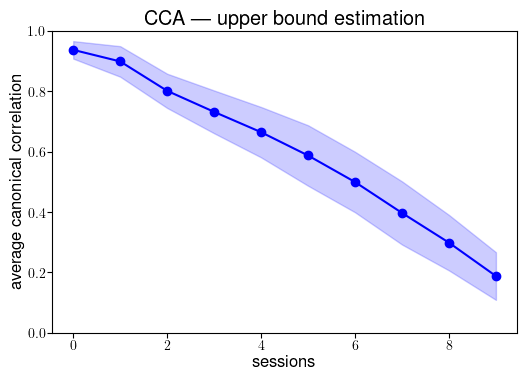

In [21]:
_,ax = plt.subplots(dpi=100)

utility.shaded_errorbar(ax, CC_upper_bound_MCx, color='b', marker = 'o', label=f'{defs.areas[2]} $n={CC_upper_bound_MCx.shape[1]}$ sessions')
plt.ylim([0,1])
plt.xlabel('sessions')
plt.ylabel('average canonical correlation')
plt.title('CCA --- upper bound estimation', usetex=True);

### Overall Figures

across monkey and within monkey together

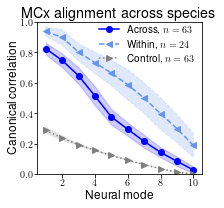

In [26]:
# plot
fig,ax = plt.subplots(ncols=1, figsize=(3,3))

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), allCCs0, color='b', marker = 'o', label=f'Across, $n={allCCs0.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_upper_bound_MCx, color='cornflowerblue', marker = '<', ls='--', label=f'Within, $n={CC_upper_bound_MCx.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_lower_bound_MCx, color='gray', marker = '>', ls=':', label=f'Control, $n={CC_lower_bound_MCx.shape[1]}$')


ax.set_ylim([0,1])
ax.set_xlim([.5,defs.n_components+.5])
ax.set_xlabel('Neural mode')
ax.set_title(f'{defs.areas[2]} alignment across species')
ax.legend(loc=(.35,.7))
ax.set_ylabel('Canonical correlation')
fig.tight_layout()

fig.savefig(params.figPath / 'across-monkey-species-cca-modes.pdf', format='pdf', bbox_inches='tight')

comapring group correlations
>Like the NN paper, _Fig. 4e_.

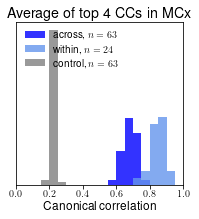

In [27]:
fig,ax = plt.subplots(ncols=1, figsize=(3,3))
bins = np.arange(0,1,0.05)

ax.hist(allCCs0[:4,:].mean(axis=0), bins=bins, density=True,
        color='b', alpha=.8, label=f'across, $n={allCCs0[:4,:].mean(axis=0).shape[0]}$')
ax.hist(CC_upper_bound_MCx[:4,:].mean(axis=0), bins=bins, density=True,
        color='cornflowerblue', alpha=.8, label=f'within, $n={CC_upper_bound_MCx[:4,:].mean(axis=0).shape[0]}$')
ax.hist(CC_lower_bound_MCx[:4,:].mean(axis=0), bins=bins, density=True,
        color='gray', alpha=.8, label=f'control, $n={CC_lower_bound_MCx[:4,:].mean(axis=0).shape[0]}$')

ax.set_title(f'Average of top 4 CCs in {defs.areas[2]}')
ax.set_xlim([0,1])
ax.set_xlabel('Canonical correlation')
ax.set_yticks([])
ax.legend(loc=2)

fig.savefig(params.figPath / 'across-monkey-species-cca-dist.pdf', format='pdf', bbox_inches='tight')